# SARIMAX

## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>SARIMAX</font></div>

## Perform standard imports and load datasets

In [156]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX


# for determining (p,q) orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# for ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose     
# for determining ARIMA orders
from pmdarima import auto_arima      


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('../Data/RestaurantVisitors.csv',
                 index_col='date',parse_dates=True)
df.index.freq = 'D'

### Inspect the data
For this section we've built a Restaurant Visitors dataset that was inspired by a <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'>recent Kaggle competition</a>. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [157]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [158]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [159]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [160]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


### Plot the source data

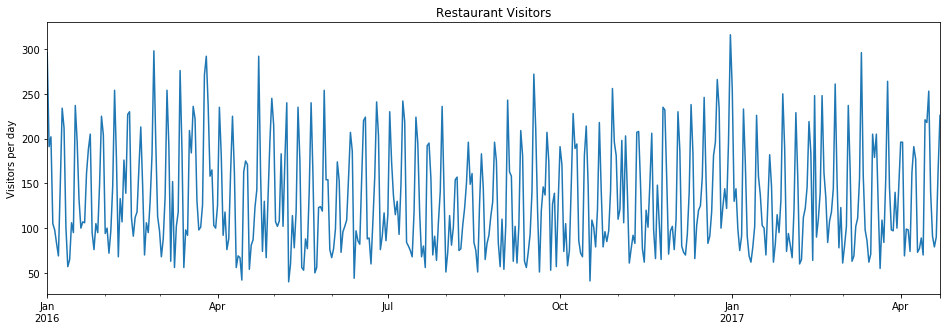

In [161]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Look at holidays: mapping out holidays
Lets take a look at holidays, does more people come to resturant during weekend?<br>
Rather than prepare a separate plot, we can use matplotlib to shade holidays behind our restaurant data.

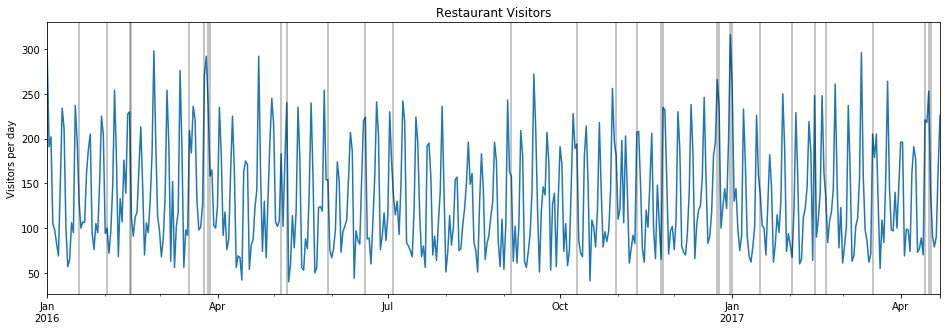

In [162]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


# for days where holiday == 1
#for x in df1.query('holiday==1').index:       
for x in df1[df1['holiday']==1].index:
    # add a semi-transparent grey line
    ax.axvline(x=x, color='k', alpha = 0.3);  

Just visually it is hard to say even after mapping out holidays, whether there are more customers in resturants during holidays.So we do NOT know if the exogenous variable "holiday" will have an impact on level `total`. But intuitively it makes sense that during holidays there will be more customers in resturants.

## 1. Atfirst we will look into labels (SARIMA)

## 2. Then we will look into label+exogenous variable as well (SARIMAX)

### Run an ETS Decomposition: check for seasonality

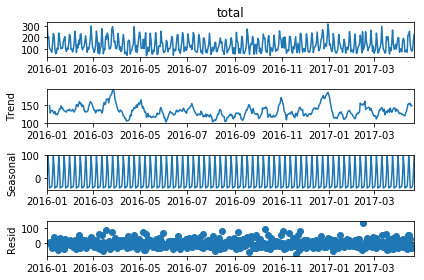

In [163]:
from statsmodels.tsa.seasonal import seasonal_decompose     
result = seasonal_decompose(df1['total'])
result.plot();

**Very strong seasonal component**

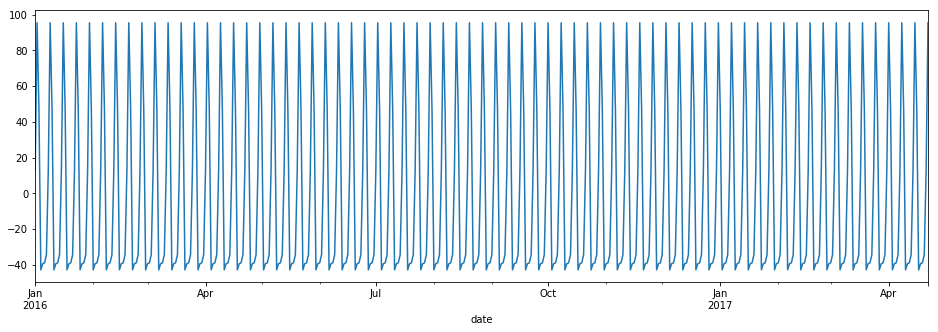

In [164]:
result.seasonal.plot(figsize=(16,5))

**There are 4 seasons per month, so seasonality of this dataset is on weekly basis.** So weekday vs weekend may have an impact just as an intuition.

## Test for stationarity

In [165]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [166]:
# already stationary, differencing NOT reqd
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [167]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2384.683
Date:                           Wed, 03 Jun 2020   AIC                           4781.366
Time:                                   19:03:32   BIC                           4806.384
Sample:                                        0   HQIC                          4791.202
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.5170     23.286      0.366      0.715     -37.122      54.156
ar.L1         -1.0000      5.426     -0.184      0.854     -11.635       9.635
ma.L1          1.0000      8.185      0.122      0.903     -15.043      17.043
ar.S.L7        0.9699      0.009    103.446      0.000       0.951       0.988
ma.S.L7       -0.7858      0.039    -20.213      0.000      -0.862      -0.710
sigma2      1009.1637   2779.974      0.363      0.717   -4439.485    6457.812
===================================================================================
Ljung-Box (Q):                       65.92   Jarque-Bera (JB):                64.65
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.75
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (1,0,0) and a seasonal order of (2,0,0,7) Now let's train & test the SARIMA model, evaluate it, then compare the result to a model that uses an exogenous variable.
### Split the data into train/test sets
We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [168]:
len(df1)

478

In [169]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### Fit a SARIMA(1,0,0)(1,0,1,7) Model

For invertible process, theta is <1 and so recent observation has more weight than observations from distant past. But when theta > 1, then weight increases as observations are from distant past. And when theta=1, then weights are constant, distant observation has same weight as more recent observation. Last 2 sceanrios does NOT make sense. Statsmodel sometime force invertibility, and it will lead to error so we need to use `enforce_invertibility=False`


NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [170]:
model = SARIMAX(train['total'],order=(1,0,1),
    seasonal_order=(1,0,1,7),enforce_invertibility=False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2148.227
Date:                           Wed, 03 Jun 2020   AIC                           4306.454
Time:                                   19:03:33   BIC                           4326.842
Sample:                               01-01-2016   HQIC                          4314.500
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8443      0.067     12.686      0.000       0.714       0.975
ma.L1         -0.6754      0.091     -7.395      0.000      -0.854      -0.496
ar.S.L7        0.9998      0.000   5808.784      0.000       1.000       1.000
ma.S.L7       -0.9540      0.024    -40.222      0.000      -1.000      -0.908
sigma2      1039.0030     52.086     19.948      0.000     936.917    1141.089
===================================================================================
Ljung-Box (Q):                       21.61   Jarque-Bera (JB):               105.13
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.76
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [171]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=start, end=end, 
    dynamic=False).rename('SARIMA(1,0,0)(1,0,1,7) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

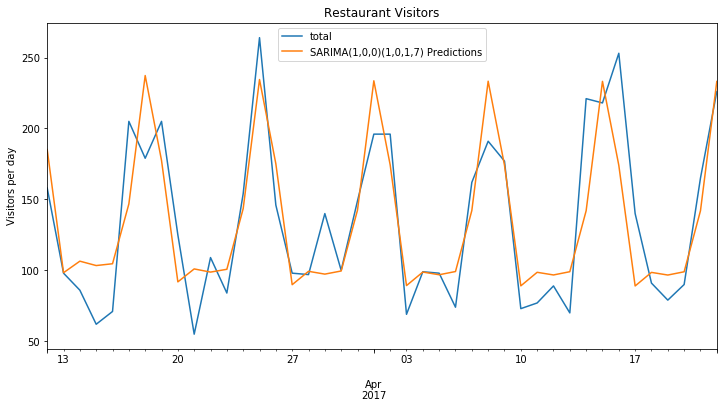

In [172]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Here we observe that sometime prediction misses the peak, sometime it doesn't. Does the model miss peak when holiday is there? If so, exogenous variable i.e. holiday has an effect on modelling the label.

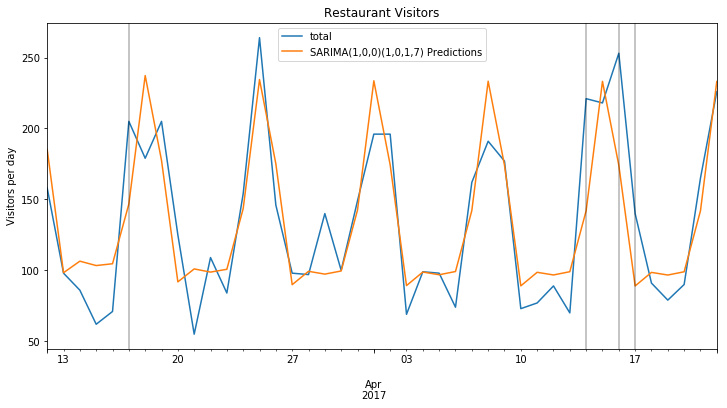

In [173]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

for x in test[test['holiday']==1].index:
    # add a semi-transparent grey line
    ax.axvline(x=x, color='k', alpha = 0.3);

### As expected, we see in some of the peak missed by the model, it coincides with holidays. So may be the model will improve if we add the exogenous variable i.e. holidays.

### Evaluate the Model

In [174]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(1,0,1,7) MSE Error: 999.8937237
SARIMA(1,0,0)(1,0,1,7) RMSE Error: 31.62109618


In [175]:
test['total'].mean()

134.26190476190476

**SARIMA Model is doing decently at a RMSE of 31 w.r.t. mean of test['total'] i.e. >100**

**CAN WE IMPROVE THE MODEL BY INTRODUCING EXOGENOUS VARIABLE?**

## 2. Adding exogenous variable to the SARIMAX model

## Now add the exog variable

We need to atfirst check including exogenous values change the order of p,d,q and P,D,Q or not! 

In [178]:
# Each month has 4 seasonal cycles as seen before
# Each cycle includes 7 rows or 7 days, thus m=7
# ADDING EXOGENOUS ELEMENT I.E. HOLIDAY
auto_arima(df1['total'],exogenous=df1[['holiday']],
                       seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2350.802
Date:                             Wed, 03 Jun 2020   AIC                           4713.603
Time:                                     19:05:27   BIC                           4738.621
Sample:                                 01-01-2016   HQIC                          4723.439
                                      - 04-22-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.8686      2.949      5.720      0.000      11.089      22.648
holiday       47.7979      4.422     10.808      0.000      39.130      56.466
ar.L1          0.1372      0.047      2.938      0.003       0.046       0.229
ar.S.L7        0.8557      0.024     35.884      0.000       0.809       0.902
ma.S.L7       -0.4157      0.060     -6.916      0.000      -0.533      -0.298
sigma2      1065.9644     74.304     14.346      0.000     920.331    1211.598
===================================================================================
Ljung-Box (Q):                       94.53   Jarque-Bera (JB):                 7.65
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.90   Skew:                             0.30
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

with exogenous variable, orders are: `SARIMAX(1, 0, 0)x(1, 0, [1], 7)`<BR>
WITHOUT exogenous variable, orders are: `SARIMAX(1, 0, 1)x(1, 0, 1, 7)`<BR>
**SO WE SEE ORDERS CHANGE AS EXOGENOUS VARIABLE IS ADDED**

In [179]:
model = SARIMAX(train['total'],exog=train[['holiday']],
                order=(1, 0, 0),seasonal_order=(1,0,1,7),
                enforce_invertibility=False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2089.208
Date:                             Wed, 03 Jun 2020   AIC                           4188.417
Time:                                     19:05:28   BIC                           4208.805
Sample:                                 01-01-2016   HQIC                          4196.463
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.9350      3.773     18.271      0.000      61.540      76.330
ar.L1          0.2101      0.044      4.762      0.000       0.124       0.297
ar.S.L7        1.0000   5.78e-05   1.73e+04      0.000       1.000       1.000
ma.S.L7       -0.9581      0.022    -43.532      0.000      -1.001      -0.915
sigma2       779.3163     44.867     17.370      0.000     691.379     867.253
===================================================================================
Ljung-Box (Q):                       36.17   Jarque-Bera (JB):                20.47
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [180]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1

# requires two brackets to yield a shape of (35,1)
# Need to  provide exogenous values for predicting period
exog_forecast = test[['holiday']]  
predictions = results.predict(start=start, end=end, 
                              exog=exog_forecast).\
            rename('SARIMAX(1,0,0)(1,0,1,7) Predictions')

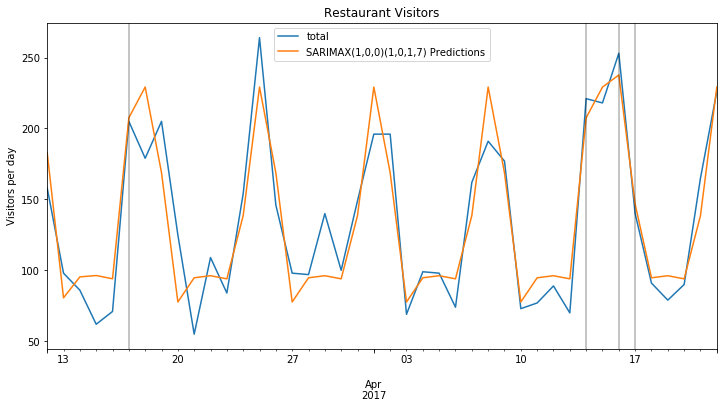

In [181]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

for x in test[test['holiday']==1].index:
    # add a semi-transparent grey line
    ax.axvline(x=x, color='k', alpha = 0.3);

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at 3/17, 4/14, 4/16 and 4/17! Let's compare evaluations:
### Evaluate the Model

In [182]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(1,0,1,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(1,0,1,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 999.8937237
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 31.62109618

SARIMAX(1,0,0)(1,0,1,7) MSE Error: 525.7737572
SARIMAX(1,0,0)(1,0,1,7) RMSE Error: 22.92975702


In [183]:
test['total'].mean()

134.26190476190476

**After adding exogenous term, rmse improved from 31 (without exogenous) to 22 (with exogenous)**

### Retrain the model on the full data, and forecast the future
We're going to forecast 39 days into the future, and use the additional holiday data

In [184]:
model = SARIMAX(df1['total'],exog=df1['holiday'],
                order=(1, 0, 0),seasonal_order=(1,0,1,7)
                ,enforce_invertibility=False)
results = model.fit()

# Trying to predict on the days where values were NaN
exog_forecast = df[478:][['holiday']]
print(len(exog_forecast))
fcast = results.predict(len(df1),len(df1)+38,
                        exog=exog_forecast).\
                rename('SARIMAX(1,0,0)(1,0,1,7) Forecast')

39


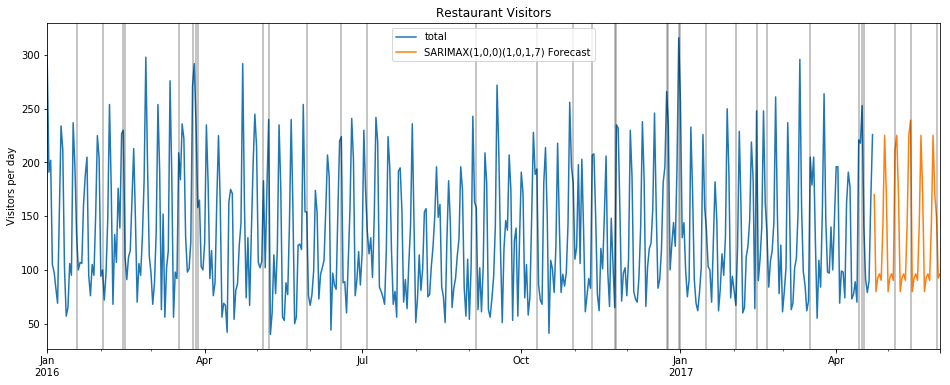

In [185]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),
                                       title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

for x in df[df['holiday']==1].index:
    # add a semi-transparent grey line
    ax.axvline(x=x, color='k', alpha = 0.3);

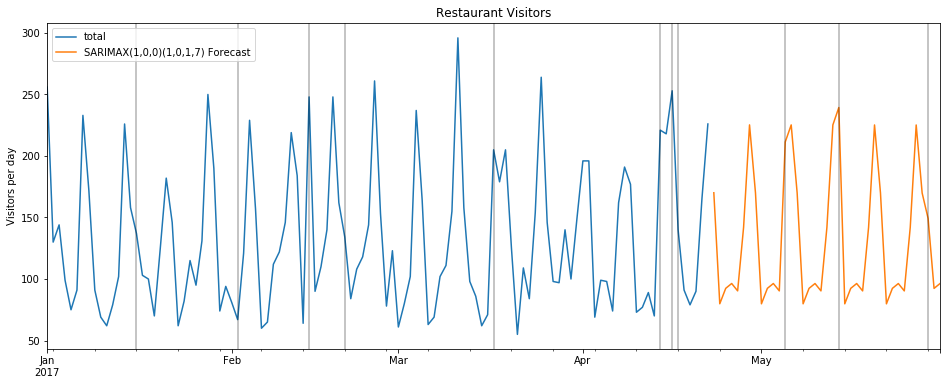

In [187]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].loc['2017-01-01':].plot(legend=True,figsize=(16,6),
                                       title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

filt = df['holiday']==1
for x in df[filt].loc['2017-01-01':].index:
    # add a semi-transparent grey line
    ax.axvline(x=x, color='k', alpha = 0.3);

**SARIMAX model performs great. But it can't capture extreme peak and bottom. But we also see it can still capture the peaks during weekends.**

**Point: In case of 2 exogenous model or more we have to pass a list [exog1, exog2]**